Pipeline illustration
====
Starting from a masked image, show all the steps

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Read in and display an image + mask

"""
import pathlib
import numpy as np
import matplotlib.pyplot as plt

img_index = "0160"

data_dir = "data/"
image_path = pathlib.Path(data_dir) / "original cut" / f"{img_index}.tif"
mask_path = pathlib.Path(data_dir) / "masks cut" / f"{img_index}.tif"

# Check that they exist
assert image_path.exists(), image_path
assert mask_path.exists(), mask_path

raw_image = plt.imread(image_path)
raw_mask = plt.imread(mask_path)

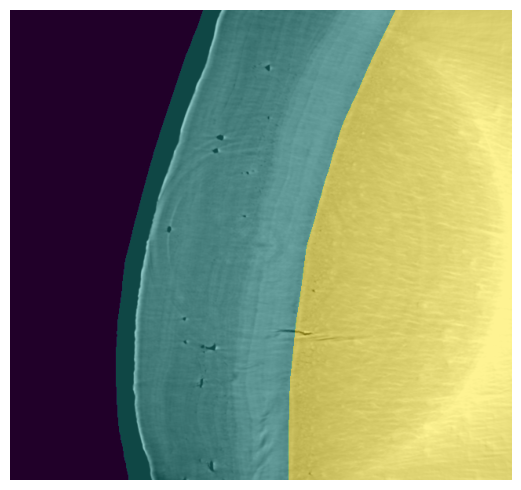

In [3]:
fig, axis = plt.subplots(1, 1, figsize=(10, 5))

axis.imshow(raw_image, cmap="gray")
axis.imshow(raw_mask, alpha=0.5)

axis.set_axis_off()

fig.tight_layout()

Straightening
----
First we want to straighten this image so the cementum layers run up/down the image.

We'll do this by finding a set of affine transformations that map points in the curved image above onto a straightened image...

In [4]:
"""
Straighten the image and mask

This works by building two meshes of points: one that curves to follow the mask, and one that is straight
We then find affine transformations that map the straight mesh to the curved mesh, and apply them to the image and mask

see straighten_mesh.ipynb for more details

"""
from cementum import straighten  # This is my library of helper functions
import timeit

# We need to choose how many points we have on the left/inside/right of the mask
n_y = 50  # How many points we have on the y-axis
n_x = 5, 5, 5  # How many points we have to the left/inside/right of the mask

start_time = timeit.default_timer()
curve_pts = straighten.mask_mesh(raw_mask, n_y, n_x)
straight_pts = straighten.straight_mesh(raw_mask, n_y, n_x)
elapsed = timeit.default_timer() - start_time

print(f"Creating meshes: {elapsed:.2f} seconds")

Creating meshes: 0.02 seconds


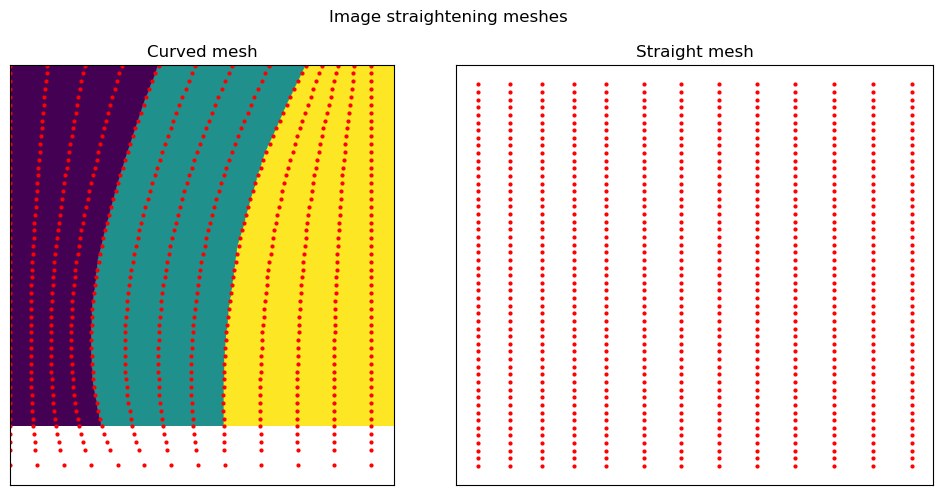

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_kw = {"marker": "o", "linestyle": "none", "markersize": 2, "color": "r"}

axes[0].imshow(raw_mask)
axes[0].plot(curve_pts[:, 0], curve_pts[:, 1], **plot_kw)

axes[1].plot(straight_pts[:, 0], straight_pts[:, 1], **plot_kw)

for axis in axes:
    axis.set_xticks([])
    axis.set_yticks([])

axes[0].set_title("Curved mesh")
axes[1].set_title("Straight mesh")

fig.suptitle("Image straightening meshes")
fig.tight_layout()

In [6]:
"""
Use these meshes to bend the image into something straight

"""
start_time = timeit.default_timer()
straight_image = straighten.apply_transformation(
    raw_image, curve_pts, straight_pts, order=0
)
img_elapsed = timeit.default_timer() - start_time

print(f"Img straightening: {img_elapsed:.2f} seconds")

Img straightening: 1.78 seconds


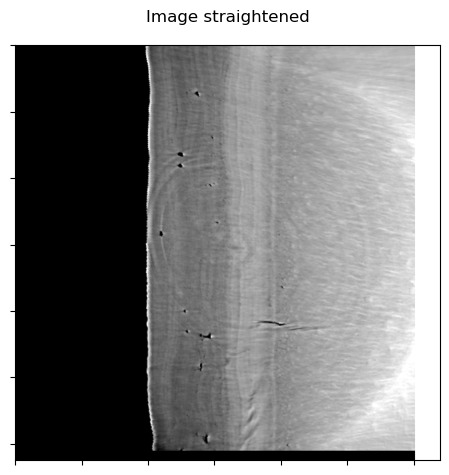

In [7]:
fig, axis = plt.subplots()

axis.imshow(straight_image, cmap="gray")
axis.set_xticklabels([])
axis.set_yticklabels([])

fig.suptitle("Image straightened")
fig.tight_layout()

Some more image processing...
----
For some reason this image straightening has now left us with white pixels along the right edge and black pixel along the bottom. Let's just remove them by hand for now, but it would probably be worth figuring out why this happens...

In [8]:
# Remove white columns
straight_image, _ = straighten.remove_white_cols(straight_image, straight_image)


# Remove black rows
straight_image = straighten.remove_padding(straight_image)

/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 25 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 9 zero rows from bottom
  warnings.warn(


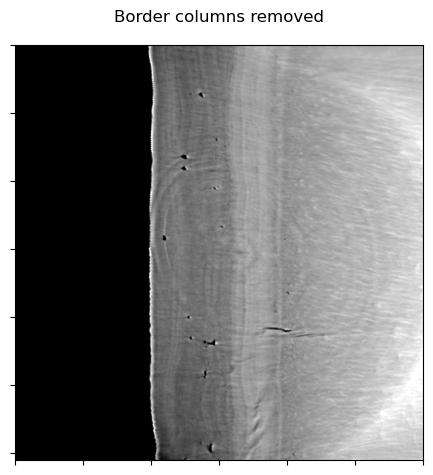

In [9]:
fig, axis = plt.subplots()
axis.imshow(straight_image, cmap="gray")

axis.set_xticklabels([])
axis.set_yticklabels([])

fig.suptitle("Border columns removed")
fig.tight_layout()

Isolating the cementum
----
We now want to isolate the cementum from this straightened image.

The background is clearly distinguishable from the start of the cementum, since there should be a step-change in the pixel intensity.

The dentin is a little harder, since the pixels are about the same brightness as in the cementum region.
We hypothesise that:
 - there is a linear increase average pixel intensity across the image (because of beam hardening?)
 - there is a small bump in intensity at the cementum-dentin boundary, due to the dense intermediate layer between the cementum and dentin.

We'll try to find the location of this bump by fitting to the average intensity of each column, using a sliding window across the image. We'll fit both a straight line, and a straight line with a bump on it, and measure the difference in fit $\chi^2$: we expect to see a sudden step in the $\chi^2$ difference when the bump is encountered, since the straight line function will no longer fit but the straight-line-with-bump will.

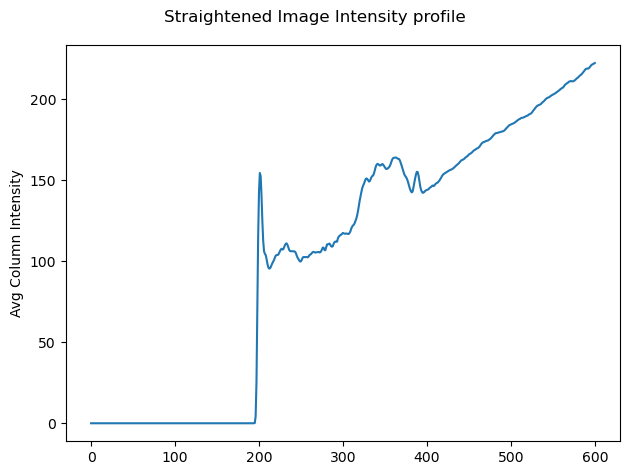

In [10]:
"""
Find the average intensity of the image along the y-axis

"""
fig, axis = plt.subplots()

avg_intensity = np.mean(straight_image, axis=0)

axis.plot(avg_intensity)

axis.set_ylabel("Avg Column Intensity")

fig.suptitle("Straightened Image Intensity profile")
fig.tight_layout()

In [11]:
"""
Find the peak location

"""
from cementum import fit_cementum

start_time = timeit.default_timer()
peak_location = fit_cementum.find_boundary(avg_intensity, domain_length=50)
elapsed = timeit.default_timer() - start_time
print(f"Finding dentin: {elapsed:.2f} seconds")

Finding dentin: 8.39 seconds


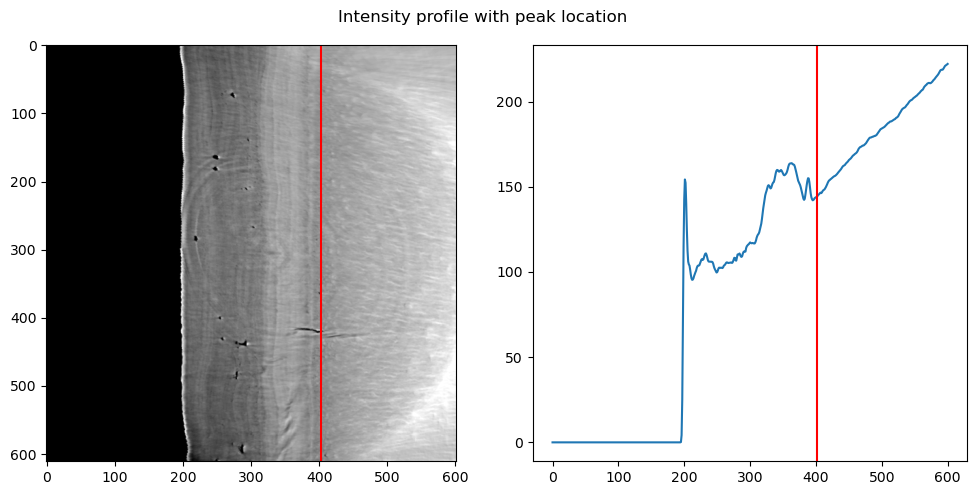

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(straight_image, cmap="gray")
axes[0].axvline(peak_location, color="r")

axes[1].plot(avg_intensity)
axes[1].axvline(peak_location, color="r")

fig.suptitle("Intensity profile with peak location")
fig.tight_layout()

This stage is by far the slowest, although there's lots of optimisations that I could make

Let's also find the cementum-background border - which is much simpler (we just look for a big step in the intensity)

In [13]:
start_time = timeit.default_timer()
edge_location = fit_cementum.find_background(avg_intensity)
elapsed = timeit.default_timer() - start_time
print(f"Finding background: {elapsed:.2f} seconds")

cropped_image = straight_image[:, edge_location:peak_location]

Finding background: 0.03 seconds


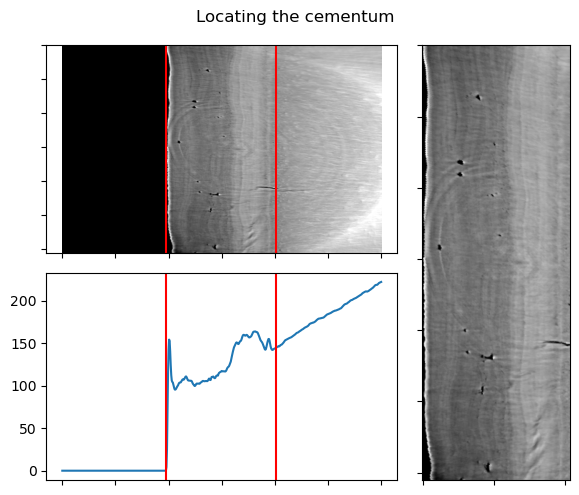

In [14]:
fig, axes = plt.subplot_mosaic(
    """
                               AAAACC
                               AAAACC
                               AAAACC
                               AAAACC
                               BBBBCC
                               BBBBCC
                               BBBBCC
                               BBBBCC
                               """,
    figsize=(6, 5),
)

axes["A"].imshow(straight_image, cmap="gray", aspect="auto")
axes["A"].axvline(peak_location, color="r")
axes["A"].axvline(edge_location, color="r")

axes["B"].plot(avg_intensity)
axes["B"].axvline(peak_location, color="r")
axes["B"].axvline(edge_location, color="r")

axes["A"].sharex(axes["B"])

axes["C"].imshow(cropped_image, cmap="gray")

for idx in "AC":
    axes[idx].set_xticklabels([])
    axes[idx].set_yticklabels([])

fig.suptitle("Locating the cementum")
fig.tight_layout()

Contrast adjustment
----
Now that we have the isolated cementum image, we can do some edge/ridge/boundary detection on it to segment the layers. This will be easier if we play with the image contrast first; we'll smooth out any noise with a Gaussian filter, and also increase the layer contrast with a steerable Gaussian filter. This works because we know the layers should run top-to-bottom in the image, so we can blur along them by just applying a vertical Gaussian filter.

In [15]:
"""
Apply both a steerable Gaussian filter and Gaussian blur to the cropped image

"""
from cementum import filter
from skimage.filters import gaussian

steerable_sigma = 0.56
blur_sigma = 2.0

start  = timeit.default_timer()
filtered_image = gaussian(
    filter.steerable_filter(cropped_image, theta=0, sigma=steerable_sigma),
    sigma=blur_sigma,
)
elapsed = timeit.default_timer() - start
print(f"Filtering: {elapsed:.4f} seconds")

Filtering: 0.0032 seconds


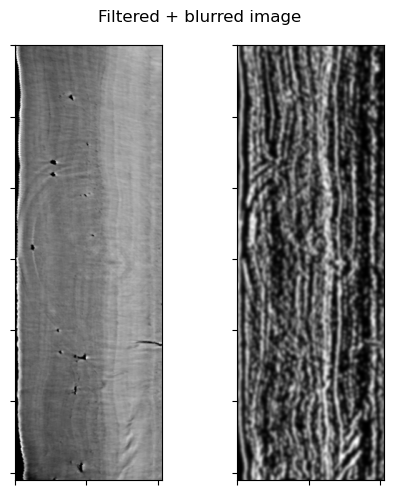

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

axes[0].imshow(cropped_image, cmap="gray")
axes[1].imshow(filtered_image, cmap="gray")

for axis in axes:
    axis.set_xticklabels([])
    axis.set_yticklabels([])

fig.suptitle("Filtered + blurred image")

fig.tight_layout()

We can now use a ridge filter to detect the layers. We expect them to run vertically in the image, so we can greatly improve its performance by using a vertical ridge filter (in this case `farid_v`).

Entirely by accident, I've found that applying a Sato filter

In [17]:
"""
Detect vertical ridges in the image

"""
from cementum import segment

start = timeit.default_timer()
filtered = segment.filter(filtered_image, ridge_threshold=12.0)
elapsed = timeit.default_timer() - start
print(f"Filtering: {elapsed:.4f} seconds")


Filtering: 0.1187 seconds


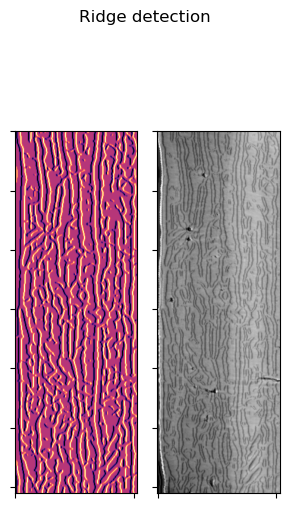

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(3, 6))
axes[0].imshow(filtered, cmap="magma")

axes[1].imshow(cropped_image, cmap="grey")
axes[1].imshow(-abs(filtered), cmap="grey", alpha=0.2)

for axis in axes:
    axis.set_xticklabels([])
    axis.set_yticklabels([])

fig.suptitle("Ridge detection")
fig.tight_layout()

In [63]:
"""
Let's also try some anisotropic diffusion to see if it helps

"""

from skimage.restoration import denoise_nl_means, estimate_sigma

sigma_est = np.mean(estimate_sigma(filtered_image))
print(f"sigma={sigma_est}")
sigma_est = 0.01

patch_kw = dict(
    patch_size=5,
    patch_distance=6,
    h=sigma_est,
)

diffused = denoise_nl_means(filtered_image, fast_mode=False, **patch_kw)

filtered_diffused = segment.filter(diffused, ridge_threshold=12.0)

sigma=0.26574091960155266


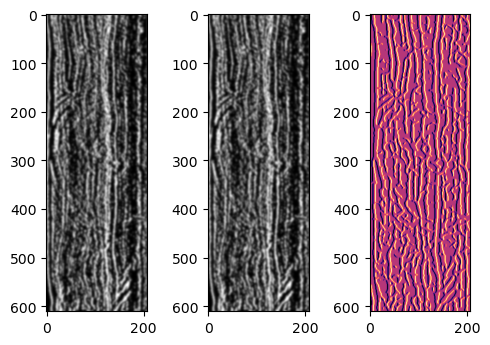

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(5, 5))

axes[0].imshow(filtered_image, cmap="gray")
axes[1].imshow(diffused, cmap="gray")
axes[2].imshow(filtered_diffused, cmap="magma")

fig.tight_layout()

In [19]:
"""
Find layer locations

"""
start = timeit.default_timer()
layer_locations = segment.layer_locations(filtered, height=35)
elapsed = timeit.default_timer() - start
print(f"Finding layers: {elapsed:.4f} seconds")

Finding layers: 0.0092 seconds


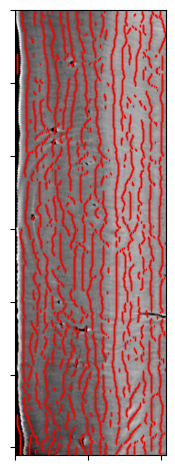

In [20]:
fig, axis = plt.subplots()

axis.imshow(cropped_image, cmap="grey")

for i, row in enumerate(layer_locations):
    axis.plot(row, [i] * len(row), "|", color="r", markersize=2)

axis.set_xticklabels([])
axis.set_yticklabels([])

fig.tight_layout()

to do: we probably want to find some consistent edges (using a fit or something?) from these points, but this is a good step for now

Layer statistics
----
As a basic summary of the layer width/locations, we can make a histogram of the number of layers and layer width per row in the image:

In [21]:
"""
Find the number and width of layers per row

"""
n_layers = []
layer_widths = []
for row in layer_locations:
    n_layers.append(len(row))
    layer_widths.append(np.diff(row))

layer_widths = np.concatenate(layer_widths)

Text(0.5, 0.98, 'Layer statistics')

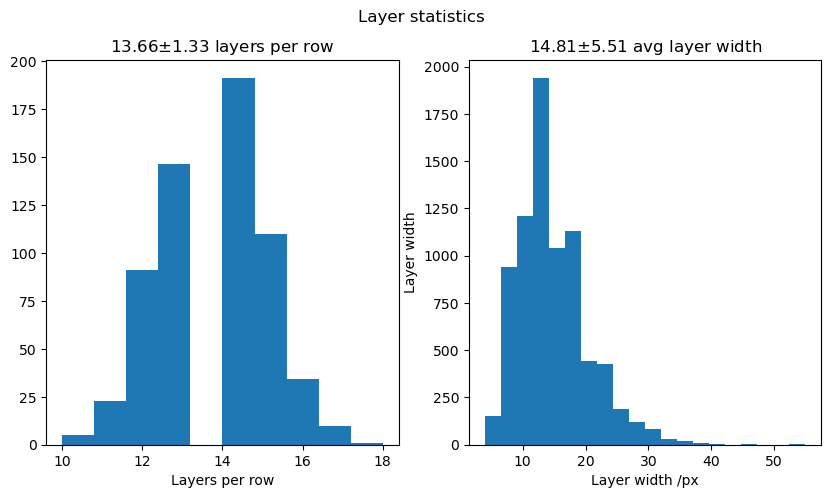

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(n_layers, 10)
axes[1].hist(layer_widths, 20)

axes[0].set_xlabel("Number of layers")
axes[0].set_xlabel("Layers per row")
axes[0].set_title(f"{np.mean(n_layers):.2f}$\pm${np.std(n_layers):.2f} layers per row")

axes[1].set_xlabel("Layer width /px")
axes[1].set_ylabel("Layer width")
axes[1].set_title(f"{np.mean(layer_widths):.2f}$\pm${np.std(layer_widths):.2f} avg layer width")

fig.suptitle("Layer statistics")